In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import wandb
from datasets import load_dataset,  Dataset
import random
import matplotlib.pyplot as plt

2025-06-06 08:53:01.836655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749199982.016680      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749199982.071178      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Kiểm tra GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
#dataset = load_dataset("NghiemAbe/Legal-training-datasets")
dataset = load_dataset("anti-ai/ViNLI-Zalo-supervised")

README.md:   0%|          | 0.00/133 [00:00<?, ?B/s]

law_vi.jsonl.gz:   0%|          | 0.00/37.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/32980 [00:00<?, ? examples/s]

In [4]:
# print(dataset["train"][0:5])

In [5]:
def restructure_data(split):
    query_list = dataset[split]['query']
    positives = dataset[split]['positive']
    #negatives = dataset[split]['negative']
    negatives = dataset[split]['hard_neg']
    
    samples = []
    for q, pos, neg in zip(query_list, positives, negatives):
        samples.append({"query": q, "document": pos, "label": 1})
        samples.append({"query": q, "document": neg, "label": 0})
    random.shuffle(samples)  # optional but recommended
    return Dataset.from_list(samples)

In [6]:
full_train_dataset = restructure_data("train")

In [7]:
# print(train_dataset[0:5])

In [8]:
split_dataset = full_train_dataset.train_test_split(test_size=0.1, seed=42)
temp_train = split_dataset["train"]
test_dataset = split_dataset["test"]

train_valid_split = temp_train.train_test_split(test_size=0.1, seed=42)
train_dataset = train_valid_split["train"]
valid_dataset = train_valid_split["test"]

In [9]:
# Kiểm tra lại
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 53427
Validation samples: 5937
Test samples: 6596


In [10]:
tokenizer = AutoTokenizer.from_pretrained("Alibaba-NLP/gte-multilingual-reranker-base", trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [11]:
def tokenize_function(examples):
    tokenized = tokenizer(
        examples["query"],
        examples["document"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    tokenized["labels"] = [float(label) for label in examples["label"]]
    return tokenized

In [12]:
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=train_dataset.column_names
)
tokenized_valid = valid_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=valid_dataset.column_names
)
tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=test_dataset.column_names
)


Map:   0%|          | 0/53427 [00:00<?, ? examples/s]

Map:   0%|          | 0/5937 [00:00<?, ? examples/s]

Map:   0%|          | 0/6596 [00:00<?, ? examples/s]

In [13]:
# Kiểm tra lại
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 53427
Validation samples: 5937
Test samples: 6596


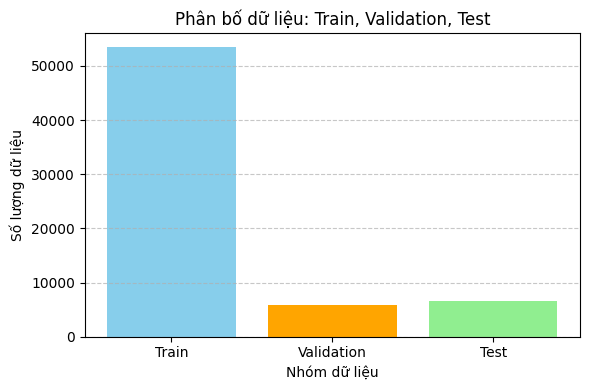

In [14]:
data_counts = {
    'Train': len(train_dataset),
    'Validation': len(valid_dataset),
    'Test': len(test_dataset)
}

# Vẽ biểu đồ cột
plt.figure(figsize=(6, 4))
plt.bar(data_counts.keys(), data_counts.values(), color=['skyblue', 'orange', 'lightgreen'])
plt.title('Phân bố dữ liệu: Train, Validation, Test')
plt.ylabel('Số lượng dữ liệu')
plt.xlabel('Nhóm dữ liệu')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
model = AutoModelForSequenceClassification.from_pretrained("Alibaba-NLP/gte-multilingual-reranker-base", trust_remote_code=True)

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/612M [00:00<?, ?B/s]

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    scores = pred.predictions.squeeze()  # shape (batch_size,)
    preds = (scores > 0).astype(int)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="binary"),
        "recall": recall_score(labels, preds, average="binary"),
        "f1": f1_score(labels, preds, average="binary"),
    }

In [17]:
wandb.login(key='f0565300fbe16c9aaca517f8d37e7fc66493f81c')

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    num_train_epochs=10,
    disable_tqdm=False,
    weight_decay=0.25,
    save_total_limit=3,
    optim="adamw_torch",
    fp16=True,
    max_grad_norm=0.6,
    warmup_ratio=0.2,
    group_by_length=True,
    report_to="wandb",
    load_best_model_at_end=True,
    label_names=['labels'],
    lr_scheduler_type="linear",
    remove_unused_columns=False
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hghaan1439 (hghaan1439-tuy-n-sinh-h-spkt-tphcm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
print(tokenized_train[0].keys())


dict_keys(['input_ids', 'attention_mask', 'labels'])


In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

/tmp/ipykernel_19/669886394.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
# Huấn luyện model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250606_085505-jbbwmug0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results
wandb: ⭐️ View project at https://wandb.ai/hghaan1439-tuy-n-sinh-h-spkt-tphcm/huggingface
wandb: 🚀 View run at https://wandb.ai/hghaan1439-tuy-n-sinh-h-spkt-tphcm/huggingface/runs/jbbwmug0
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.086500,0.007781,0.705744,0.634136,1.000000,0.776112
1,0.003400,0.004176,0.965976,0.937461,1.000000,0.967721
2,0.001600,0.001946,0.998147,0.996380,1.000000,0.998187
3,0.000700,0.002156,0.998147,0.996380,1.000000,0.998187


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1668, training_loss=0.023043447815114075, metrics={'train_runtime': 19400.9138, 'train_samples_per_second': 27.538, 'train_steps_per_second': 0.215, 'total_flos': 7.478687595449549e+16, 'train_loss': 0.023043447815114075, 'epoch': 3.998802395209581})

In [21]:
# Lưu mô hình
model.save_pretrained("rerank_model")
tokenizer.save_pretrained("rerank_model")

('rerank_model/tokenizer_config.json',
 'rerank_model/special_tokens_map.json',
 'rerank_model/tokenizer.json')